# Text classification and clustering 

Our data is represented by 20 samples of text from 20 authors. We will use this data for two tasks:
1. Classification
    - will use a SVM to build a model which predicts which author wrote a text
2. Clustering
    - by using KMeans, DBSCAN and Hierarchical Clustering, we will explore our data and try to find structure in it

We will also use PCA for dimensionality reduction during both tasks.

In [1]:
# Some IPython magic
# enable multiple output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Put these at the top of every notebook, here nbagg is used for interactive plots
%reload_ext autoreload
%autoreload 2
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# set floating points write format
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

Below is a glimpse of data. First cleaning we make is to drop unnecesary columns. In our case, this column is 'Unnamed: 0'  
In what follow, we will call each text sample from an author a **document**



In [2]:
# read data
data = pd.read_csv('Ghidoveanu A. Mihai.csv')
data.head()
data = data.drop(columns = 'Unnamed: 0')

,Unnamed: 0,Edmund Burke,John Bunyan,Edward Phillips Oppenheim,Harold Bindloss,Lord Byron,Joseph Conrad,Thomas Carlyle,Henry James,Herbert George Wells,...,Bret Harte,Charles Darwin,Nathaniel Hawthorne,Daniel Defoe,Robert Louis Stevenson,Louisa May Alcott,Rudyard Kipling,P G Wodehouse,Jack London,Frank Richard Stockton
0,0,repose. I could hardly serve you _as I have do...,that he would make the very bed shake under hi...,THE DEVIL'S PAW By E. Phillips Oppenheim ...,"saloon, which was partly filled with smoke, an...",unnoticed. Some will be directly pointed out; ...,pondering upon the faded memories of freedom. ...,"three cups with or without milk [likes coffee,...","her. She must wait, at any rate, she should se...",in this interval the race had lost its manline...,...,"came here. That's all! It isn't much, Tom. You...","flying, on account of their tumbling so much a...",place of study and retirement. There was a fa...,"enemy's country, entered their associated coun...","BAXTER, _WRITER TO THE SIGNET_. MY DEAR CHARL...",face that she hastened to assure him no one sh...,always told that lie in the other places. Leav...,"were there and you know, of course, but I shou...","little bedroom, the occupant of which, a glove...",it had not been for this unfortunate and jealo...
1,1,"sufficient. X. I further assert, that even u...","in the behalf of sinners, in that God hath giv...","""except this--that you speak the truth."" He w...","dressed in white flannel, with a straw hat and...","thee hence, 140 ...","all black in the pale wall, stood open as he h...","disastrous and unfortunate he had yet made, or...","he continued without heeding. ""That's what I ...","into the great, multitudinous world; this time...",...,"slight platform. A grizzled, hard-faced old ma...","greatly preponderate in the first, whilst in t...","accordance with their hoggish perversity, but ...","(the weather being hot, and days long, for thi...",Ueba_ and a biscuit-box--the suggesting incide...,JACK AND JILL By Louisa May Alcott To ...,"twisted into knots, riven with rents and diamo...",Mr. Peters? Don't you think there is danger he...,"All of which I submit. Never, in my life of D...","by. He filled it, then he sat down and wiped h..."
2,2,immediately proceeded to appoint him a guardia...,justified in the sight of God; so it is also a...,alone possess it. It rests with me whether the...,"the rest of the voyage, but when two hours lat...","THE WORKS OF LORD BYRON. A NEW, REVI...","incredible, restrained him. The captain came ...","here, on the very threshold, protest against i...",chronicle would seem only of the smallest beer...,"blackmailing Book or News Trust squalidly ""fig...",...,Comandante as Dona Barbara had answered HIM? H...,"height, very unusual on this side of the conti...","facts, I could not have believed him one whit ...",that the kings of France and Spain were united...,"Mein Herz ist im Hochland, wo immer ich geh._""...","of penitence and thankfulness. ""Call them now...","brimstone Spanish, and he swung down on our ra...",more about your unfortunate affair with that g...,the things he has seen in his waking life. But...,and we were all thrown into the sea. As none o...
3,3,Neither must we think that the whole revenue o...,"shall but in one point offend, Breaks the whol...",simple answer: What are your views as to Woman...,"had been scrambling over mossy rocks, and his ...",marble where her feet ...,"their Ruler, the enemy of his enemies, known t...",into the current epigrammatic redaction; the a...,was checked by the Master's radiance. It was ...,contentment. §2 One is reminded of those ho...,...,"employer's chambers in Sacramento, and handed ...","to verify this assertion, and have found it tr...","the threshold of the manor-house, and the miss...","the Divine Powers, for saving, my life, when t...","the middle of Chapter IV. Like enough, when it...","and there was no time to ask leave, but it was...","You've too much conceited Brain, too littl

We have data represented by text, but our machine learning models work with numerical data. One way to represent text in a numerical way is the **Bag Of Words** representation.  
This means that we transform a document in an array of words whose values are each word's count of appearances in a document  
e.g. *"My boy is my boy" -> (2, 2, 1)*  
  
But this form of count data gives preference to the most common words in documents, which are usually not at all relevant to the author style : *"the", "and", "you", "I"*  
A safe bet is to choose to ignore words which appear in 99% documents. There also exists a metric that takes how often words appear in other documents into account.  
  
**TF-IDF** (Term Frequency - Inverse Document Frequency) is a metric that favors terms which appear often in a document, and not often in many documents. That is, we will find words which are more specific to the writer.
Thus, our final solution is to use tf-idf for transforming the counts. 


 # Task 1. Text Classification
 
As said above, we will use an SVM to classify texts to their authors.  
We have 400 samples of documents, each document having a feature for each word in the vocabulary.  
This leads to a large amount of features, and given that not all features have a value because not every document contains all the possible words, our data is a **sparse matrix**.  
   
Labels for our data will be the author names, encoded into numbers. We have 20 authors and each author has 20 documents, so we will end up with an array of 400 labels, one for each document in our data.  

When we split data into train and test, it is important to take equal amounts of samples from each author because we want to be able to predict new documents to the same authors that we have learnt from. That's where **stratification** comes into play. It is a method of sampling that does just that.

Also, we *tfidf vectorize* our dataset **after splitting** into train and test datasets. That is because in a real life scenario, we might find words in the test dataset that are not available in the train dataset. And the vectorizer creates a feature for each of the words encountered. Thus, we will meet words that won't be represented by some features.

In [ ]:
%%time
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split

def make_tfidf(X):
    tfidf = text.TfidfVectorizer(max_df=0.9)
    tfidf.fit(X)
    return tfidf.transform(X), tfidf

# we need an array of texts to feed the vectorizers
# so we flatten the dataframe, with stories from the same author one after the other
corpus = data.values.ravel(order = 'F')

RSTATE = 42

# we split in train and text examples before counter vectorization
labels, authors = pd.factorize(data.columns.values)
y = np.array([label for label in labels for _ in range(20)])
x_train, x_test, y_train, y_test = train_test_split(corpus, y, stratify=y,test_size=0.3, random_state = RSTATE)

## Preprocessing text and turning it into a bag of words tf-idf model
x_train, tfidf = make_tfidf(x_train)
x_test = tfidf.transform(x_test)

In [ ]:
# %%time
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# C gives way to correct classification of training examples (larger value of C) 
#   gives way to maximization of the decision function’s margin.(lower value of C)
# gamma -- the inverse of the radius of influence of samples selected by the model as support vectors
svc = svm.SVC(cache_size = 1000, C = 10, kernel='linear')
clf = GridSearchCV(estimator = svc, cv = 3, refit = True, param_grid=[{}], iid=False)
svc.fit(x_train, y_train);
print('After PCA score is ', svc.score(x_test, y_test))

## Tuning the hyperparameters

The SVM has many hyperparameters that we have to try to build a better model. Firstly, it has 4 types of **kernel** functions:
1. linear
2. rbf (gaussian)
3. poly (polynomial)
4. sigmoid

Then, because the sklearn uses the Soft-margin SVM, we can tune the **C** parameter, which does the regularization of the model.  
A large value of C makes the decision margin narrower if it can correctly classify more training examples this way. This leads to a higher bias and a lower variance.
On the other hand, a small value of C makes the decision margin larger, with the cost of misclassifying some training examples. This leads to a lower bias and a higher variance.

For *rbf* and *sigmoid* kernels only, we also have the **gamma** parameter.

For *poly* kernel only, we have the **degree** parameter. It controls the degree of the polynomial function used to train the svm.

In below code, we perform a **Grid-Search** for each kernel on various set of values for hyperparameters. After we find the best hyperparameters for each kernel, we compare all the kernels at the end and choose the best parameter set.  
We compare our results with each parameter by performing a **K-Fold** with 3 folds on our training samples. We hold out a **test set** to be sure we don't overfit the parameters on the validation one.
  
Besides the *linear* kernel, we have to tune two parameters at a time : (*C* and *gamma*) or (*C* and *degree*). Because the grid search performs a cartesian product between the parameter value sets, it can take a rather long time if we try many parameter values at once.  
To avoid this, we will take the following approach:
1. Try three values in a logarithmic scale of 100 (e.g. For *C* and *gamma* we try values in (0.01, 1, 100).
2. We find best *C* and *gamma* (e.g. *C* = 100, *gamma* = 1)
3. Try three values in a logarithmic scale of 10, centered around the best values found above
    - e.g *C* in (10, 100, 1000)
    - e.g. *gamma* in (0.1, 1, 10)
4. We find best *C* and *gamma* (e.g. *C* = 1000, *gamma* = 0.1). Check scores on the test set and compare them with the previous best to be wary of overfit
5. Be creative ! Maybe try more values on a linear scale after we found our best on a logarithmic. 

**WARNING !!!** : Next cells usually took up to 4 minutes per run on my machine. 

**Important Note !!!** : Even though we always compute and print the score on the test population, we use it only to check if we did overfit on the validation set. We tune the parameters to the validation set.

In [ ]:
# Utilities to cross validate a classifier with a grid search of params and print the results
# @clf needs to be GridSearchCV
def cross_validate(clf, params, x_train = x_train, x_test = x_test, y_train = y_train, y_test = y_test):
    clf.param_grid = params
    clf.fit(x_train, y_train)
    scores = {'score' : clf.best_score_,
                 'params' : clf.best_params_, 
                 'tscore' : clf.best_estimator_.score(x_test, y_test)}
    return scores, clf

def print_results(scores):
    kernel = scores['params']['kernel']
    print('For {:10} : validation {:.2f} test {:.2f} - {}'.format(scores['params']['kernel'], scores['score'], 
                                                                      scores['tscore'], scores['params']))

In [9]:
X

NameError: name 'X' is not defined

### Linear Kernel Tuning

In [8]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

NameError: name 'X' is not defined

In [ ]:
params = [{'kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],
            'C' : [0.01, 0.1, 1, 10, 100, 1000, 10000],
             'gamma' : [0.01, 0.1, 1, 10, 100, 1000],
             'degree' : [0.01, 0.1, 1, 10 ,100, 1000, 10000, 10000]}]

scores = {} # to store scores and parameters for each of the kernels

scores, clf = cross_validate(clf, params)
print_results(scores)


In [128]:
%%time
# tuning svc hyper parameters
# Firstly we try the linear kernel with many C's
linear_params = [{'kernel' : ['linear'],
            'C' : [0.01, 0.1, 1, 10, 100, 1000]}]

scores = {} # to store scores and parameters for each of the kernels

linear_scores, clf = cross_validate(clf, linear_params)
print_results(linear_scores)

# we found our best : 
scores['linear'] = linear_scores

For linear     : validation 0.96 test 0.97 - {'C': 10, 'kernel': 'linear'}
Wall time: 3min 10s


### RBF Kernel Tuning

In [7]:
%%time
# for rbf, we try at first lesser values for parameters
# because rbf kernel has more parameters to try and thus it would take more computational time
# then try more values based on the best found
rbf_params = [{'kernel' : ['rbf'],
              'C' : [0.01, 1, 100],
              'gamma' : [0.01, 1, 100, 'auto']}]

rbf_scores, clf = cross_validate(clf, rbf_params)
print_results(rbf_scores)

For rbf        : validation 0.95 test 0.97 - {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Wall time: 5min 21s


In [129]:
%%time

# after this set of params we see that best (C, gamma) = (100,1)
# so we try more closer values to the optimal C and gamma found above
rbf_params[0]['C'] = [10, 100, 1000]
rbf_params[0]['gamma'] = [0.1, 1, 10]
rbf_scores_2, clf = cross_validate(clf, rbf_params)
print_results(rbf_scores_2)


For rbf        : validation 0.95 test 0.97 - {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Wall time: 4min 14s


Now we see that we obtain the same values for this set of parameters.

We know that *C* and *gamma* are in a trade-off of bias and variance, so increasing *C* and lowering gamma gets the same results from a moment on.  
Thus, we will keep this best **(10, 0.1)** because a smaller *C* leads to smaller training times and the parameters being more ponderate makes the model less prone to overfitting.

In [130]:
# We found our best 

scores['rbf'] = rbf_scores

### Poly Kernel Tuning

In [131]:
%%time

# now we try to tune the polynomial kernel with the same strategy as for rbf, because we have many parameters to choose from
poly_params = [{'kernel' : ['poly'],
            'C' : [0.01, 1, 100],
            'degree' : [2, 10, 100]}]
poly_scores, clf = cross_validate(clf, poly_params)
print_results(poly_scores)

D:\Programs\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For poly       : validation 0.83 test 0.93 - {'C': 0.01, 'degree': 10, 'kernel': 'poly'}
Wall time: 4min 37s


After this trial we see that best parameters are (*C*, *degree*) = (0.01, 10)  
We now try another set of values around (0.01, 10).

In [132]:
%%time
poly_params[0]['C'] = [0.01]
poly_params[0]['degree'] = [10, 20, 30]
poly_scores_2, clf = cross_validate(clf, poly_params)
print_results(poly_scores_2)

D:\Programs\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For poly       : validation 0.83 test 0.93 - {'C': 0.01, 'degree': 10, 'kernel': 'poly'}
Wall time: 1min 38s


Parameters kept the same best value.

In [133]:
# %%time
# poly_params[0]['C'] = [ 1000, 10000]
# poly_params[0]['degree'] = [2, 3]
# poly_scores_3, clf = cross_validate(clf, poly_params)
# print_results(poly_scores_3)

In [134]:
# We found our best

scores['poly'] = poly_scores

### Sigmoid Kernel Tuning

In [10]:
%%time
# Now try the sigmoid kernel
sigmoid_params = [{'kernel' : ['sigmoid'],
            'C' : [0.01, 1, 100],
            'gamma' : [0.01, 1, 100, 'auto']}]
sigmoid_scores, clf = cross_validate(clf, sigmoid_params)
print_results(sigmoid_scores)

For sigmoid    : validation 0.96 test 0.97 - {'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}
Wall time: 5min 19s


In [198]:
%%time
# For now the best params are (C, gamma) = (100, 1)

sigmoid_params[0]['C'] = [10, 100, 1000]
sigmoid_params[0]['gamma'] = [0.1, 1, 10]
sigmoid_scores_2, clf = cross_validate(clf, sigmoid_params)
print_results(sigmoid_scores_2)

For sigmoid    : validation 0.92 test 0.97 - {'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}
Wall time: 514 ms


We see no change in results after changing the hyperparameter range, so we keep the best value *(C, gamma)* = *(100,1)*  

In [207]:
# We found our best

scores['sigmoid'] = sigmoid_scores

Now we compare our results for all the kernels up till now. 

In [209]:
# Now we compare the results for all the kernels tried
for k, v in scores.items():
    print('{:10} : validation {:.2f} ---- test {:.2f} : {}'.format(k, v['score'], v['tscore'], v['params']))
# scores

linear     : validation 0.91 ---- test 0.96 : {'C': 10, 'kernel': 'linear'}
sigmoid    : validation 0.92 ---- test 0.97 : {'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}
poly       : validation 0.82 ---- test 0.86 : {'C': 100, 'degree': 2, 'kernel': 'poly'}
rbf        : validation 0.92 ---- test 0.96 : {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


### Decision on tuning  
We make our final choice below.

In [116]:
svc.kernel = 'rbf'
svc.C = 10
svc.gamma = 0.1
svc.fit(x_train, y_train);
print('Our score on the test set is ', svc.score(x_test, y_test))

SVC(C=100, cache_size=1000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Our score on the test set is  0.941666666667


## Task 1.2 Dimensionality Reduction
We use **PCA** to reduce the dimensionality of our dataset and see how our model performs on the reduced dataset.  
Sklearn package uses **SVD** (Singular Value Decomposition) to perform *PCA*. Using *SVD* on count / tf-idf data, as we have now, is called **LSA** (Latent Semantic Analysis).  
Sklearn *SVD* implementation for sparse inputs is *TruncatedSVD*. But given that we don't have many samples, it will not come at a great cost to transform our sparse matrix in a dense one. This comes with the benefit of using *PCA*'s feature of reducing data to as many dimensions as needed to explain a given variance ratio.  
To keep most of our data information, we will keep **99%** variance for the dataset.  

In [135]:
%%time
from sklearn.decomposition import PCA
def reduce_dimensions(X, dimensions = 0.99):
    pca = PCA(dimensions, random_state = RSTATE).fit(X)
    return pca.transform(X), pca

rx_train, pca = reduce_dimensions(x_train.todense())
rx_test = pca.transform(x_test.todense())
svc.fit(rx_train, y_train);
svc.score(rx_test,y_test)

Wall time: 11.4 s


We notice that the score on test set goes down a little after pca, but not much. Given how many features had our data in the first place, reducing its dimensionality in this way will lead to much faster training times.


# Task 2. Clustering documents
To explore data and find structure in it, we will try to clusterize the data.  
We will reduce data dimensions using PCA. We will reduce to as many dimensions needed to explain **99%** of the variance.

We use three clustering algorithms :
1. *Kmeans*
2. *DBSCAN*
3. *Hierarhical Clustering* (represented by *AgglomerativeClustering* in sklearn)

We score these algorithms using following metrics:
1. *Silhouette score* : measures how similar is a sample to its cluster and how different it is to other clusters
    - The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.  
    - Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
2. *Homogeneity score* 
    - A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
3. *Completeness score*
    - A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.

## Task 2.1 Exploratory plots

Our count/tf-idf representation gives a sparse matrix with many features, and in this way, many dimensions. So it is impossible to visualize in a plot.  
But by using **PCA** we can reduce our data to 2 or 3 features and plot it in a 2d, respectively 3d, setting.  

Results can be seen below.

In [148]:
## Utilities for plotting data 

from matplotlib.lines import Line2D
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D

rcParams.update({'font.size': 6})

# 20 colors with high contrast from the Helpful Internet
# https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
unique_colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabebe',
    '#469990', '#e6beff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9']
def marker_with(color, label, marker = '.'):
    return Line2D([0],[0], marker = marker, color = color, label = label)

def plot_data(rX, subplot_poz, dimensions = 2, unique_colors = unique_colors):
    # give one of the unique 20 colors to each document label 
    colors = [color for color in unique_colors for _ in range(20)]
    # create a 3d or 2d plot based on parameters
    fig = plt.figure()
    if dimensions == 3:
        ax = fig.add_subplot(subplot_poz, projection='3d');
        ax.scatter(rX[:,0], rX[:,1], rX[:,2], marker = '.', c = colors);
        ax.set_title('Texts by author - 3D')
    else:
        ax = fig.add_subplot(subplot_poz)
        ax.scatter(rX[:,0], rX[:,1] , marker = '.', c = colors);
        ax.set_title('Texts by author - 2D')
    # add legend based on the choosen colors and the author names
    legend_handles = [marker_with(color, author, 'o') for author, color in zip(authors,unique_colors)]
    ax.legend(legend_handles, authors);
    fig.tight_layout()


In [141]:
%%time
# make vectorization of entire corpus without splitting
X, _ = make_tfidf(corpus)
X = X.todense()

Wall time: 1min 26s


<IPython.core.display.Javascript object>


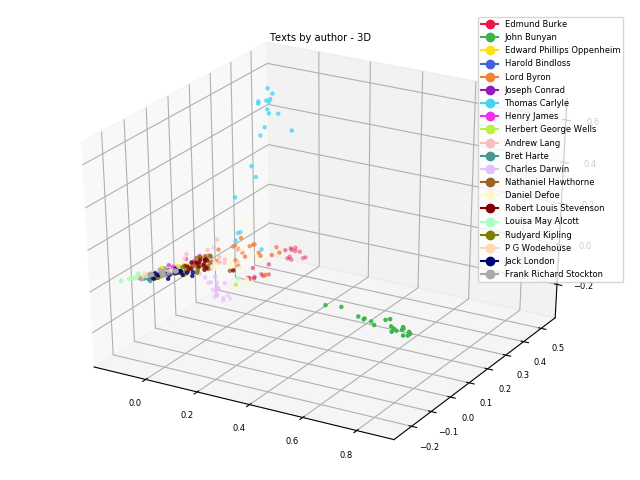

<IPython.core.display.Javascript object>


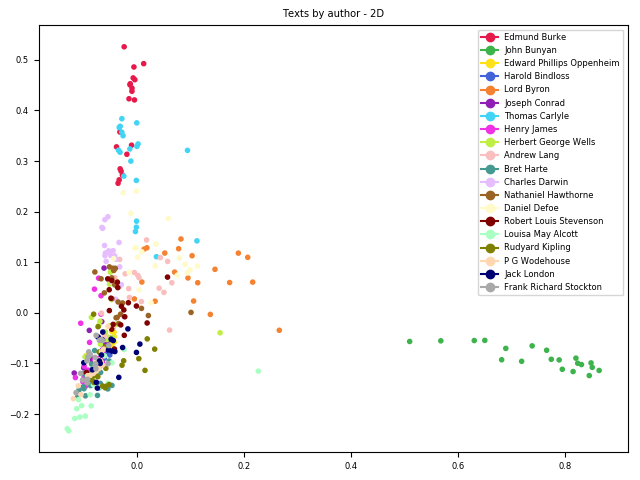

Wall time: 10.9 s


In [149]:
%%time
# use pca to reduce dimensionality to make dataset visualizable
rX, _ = reduce_dimensions(X, 3)
plot_data(rX, 111, dimensions=3)
rX, _ = reduce_dimensions(X, 2)
plot_data(rX, 111, dimensions=2)


## Now Clustering

In [168]:
# Now clustering
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
rX, _ = reduce_dimensions(X)
dbscan = DBSCAN(eps = 1, min_samples = 5)
clusters = []
clusters.append(dbscan.fit_predict(rX))


In [164]:
no_clusters = clusters[0].max()

In [169]:
%%time

kmeans = KMeans(n_clusters=no_clusters, init = 'random')
clusters.append(kmeans.fit_predict(rX))


Wall time: 203 ms


In [170]:
%%time
hierarchical = AgglomerativeClustering(n_clusters = no_clusters)
clusters.append(hierarchical.fit_predict(rX))


Wall time: 38 ms


In [171]:
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score

print('Silhouette : ', [silhouette_score(X, cluster) for cluster in clusters])
print('Homogeinity : ', [homogeneity_score(y, cluster) for cluster in clusters])
print('Completeness : ', [completeness_score(y, cluster) for cluster in clusters])

Silhouette :  [0.040605232641092941, 0.044350683841450696, 0.045141741283111811]
Homogeinity :  [0.24635918520097347, 0.42407413445792763, 0.30637343086899516]
Completeness :  [0.78200844990673657, 0.87107343196176046, 0.91715648532774607]


We tried to estimate the number of clusters using DBSCAN and then used this number of clusters for the other algorithms.  
We notice that **K-Means** works the best.


## Task 2.2 Visualising Clusters

In [84]:
rX = reduce_dimensions(X,2)

In [172]:
def plot_clusters(X, clusters, dimensions = 2, titles = []):
    black = '#000000'
    if dimensions == 3:
        fig, axs = plt.subplots(nrows = 1, ncols = len(clusters), subplot_kw={'projection': '3d'})
    else:
        fig, axs = plt.subplots(nrows = 1, ncols = len(clusters))
    fig.suptitle('Document Clustering')
    fig.tight_layout()
    for index, clustering in enumerate(clusters):        
        labels = clustering
        cluster_labels = np.unique(labels).tolist()
        cluster_colors = unique_colors[:len(cluster_labels)]
        colors = [cluster_colors[label] for label in labels]
        ax = axs[index]
        if dimensions == 3:
            ax.scatter(rX[:,0], rX[:,1], rX[:,2], s = 20, c = colors, marker = '.')
            ax.set_title('{} - 3D'.format(titles[index]))
        else:
            ax.scatter(rX[:,0], rX[:,1], s = 20, c = colors, marker = '.')
            ax.set_title('{} - 2D'.format(titles[index]))
        legend_handles = [ marker_with(color, label) if label != -1 else marker_with(black, 'outlier') for label, color in zip(cluster_labels,cluster_colors)]
        ax.legend(legend_handles, cluster_labels)

<IPython.core.display.Javascript object>


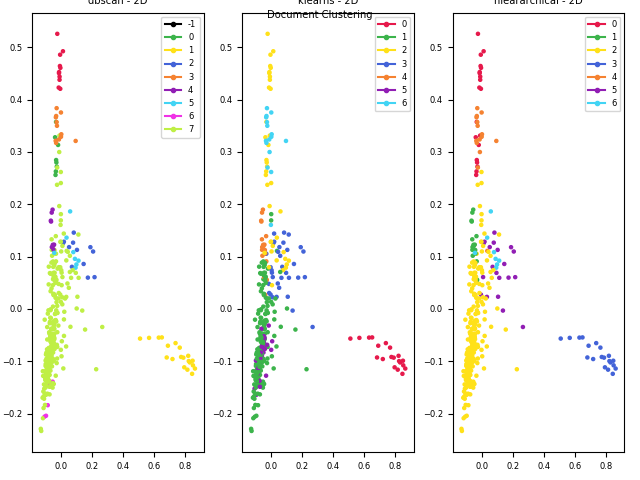

In [173]:
plot_clusters(X, clusters,dimensions = 2, titles = ['dbscan', 'klearns', 'hieararchical'])